## Graphical Exponential Smoothing on S&P500

In [1]:
import warnings
import matplotlib
import pandas as pd
import numpy as np
from IPython.display import Image
from pylab import rcParams
from IPython.display import Image
warnings.filterwarnings('ignore')
# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [16, 9]
#np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', None)

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, Lasso
import time
import pingouin as pg

In [3]:
from yahoo_fin import stock_info as si

In [4]:
sp = si.tickers_sp500()

In [5]:
sp_data = yf.download(sp,'1999-01-01','2023-05-06')

[*********************100%***********************]  503 of 503 completed


In [6]:
log_close = sp_data['Adj Close'].apply(np.log)

In [7]:
log_close.dropna(how='all',axis=1,inplace=True)

In [8]:
sp_close_ret = log_close.diff().iloc[1:]

In [9]:
pc2 = sp_close_ret.pcorr().dropna(thresh=5,axis=1).dropna(thresh=5,axis=0)

In [10]:
cols = pc2.columns.tolist()

In [11]:
len(cols), len(log_close.columns.tolist()), len(sp_close_ret.columns.tolist())

(333, 503, 503)

In [12]:
log_close = log_close[cols]
sp_close_ret = sp_close_ret[cols]

In [13]:
t=1000
idx = sp_close_ret.index[(t-1000):t]
df = log_close.loc[idx].dropna(how='all',axis=1)
pc = sp_close_ret.loc[idx].dropna(how='all',axis=1).pcorr().dropna(thresh=5,axis=1).dropna(thresh=5,axis=0)
df = df[pc.columns.tolist()]
G = np.where(np.abs(pc)>0.08,1,0)
np.fill_diagonal(G,0)
Vol = sp_data['Volume'].loc[idx][pc.columns.tolist()].dropna(how='all',axis=1)
Vol.fillna(Vol.mean(),inplace=True)
Vol = Vol/1000000
W = G*np.tile(Vol.iloc[-1].values,(G.shape[0],1))
W = W/W.sum(1)[:, np.newaxis]
pred_x = [df.iloc[-1]]
pred_b = [pd.Series(np.tile(0,len(pc.columns.tolist())),index=pc.columns.tolist())]
x = pred_x[-1]
b = pred_b[-1]
alpha = pd.Series(np.tile(0.5,len(pc.columns.tolist())),index=pc.columns.tolist())
lda = pd.Series(np.tile(0.5,len(pc.columns.tolist())),index=pc.columns.tolist())
beta = pd.Series(np.tile(0.5,len(pc.columns.tolist())),index=pc.columns.tolist())
mu = pd.Series(np.tile(0.5,len(pc.columns.tolist())),index=pc.columns.tolist())
a = alpha.values
la = lda.values
bta = beta.values
m = mu.values
W2 = np.eye(len(pc.columns.tolist())) + np.diag(la).dot(W)
W3 = np.eye(len(pc.columns.tolist())) + np.diag(m).dot(W)
pred_xx = np.diag(a).dot(W2.dot(df.iloc[t-1])) + np.diag(1-a).dot(x.values+b.values)
pred_bb = np.diag(bta).dot(W3.dot(pred_xx - x.values)) + np.diag(1-bta).dot(b.values)
ck = np.where(abs(pred_bb) > abs(pred_xx)*0.05,0,1)
pred_bb = pred_bb*ck
pred_x.append(pd.Series(pred_xx,index=pc.columns.tolist()))
pred_b.append(pd.Series(pred_bb,index=pc.columns.tolist()))
actual_x = log_close.iloc[t][pc.columns.tolist()]
actual_b = log_close.iloc[t][pc.columns.tolist()] - log_close.iloc[t-1][pc.columns.tolist()]
for i in pc.columns.tolist():
    if actual_x.loc[i] > pred_x[-1].loc[i]*1.015:
        if alpha.loc[i] + 0.001 < 1:
            alpha.loc[i] = alpha.loc[i]+0.001
    elif actual_x.loc[i] < pred_x[-1].loc[i]*0.985:
        if alpha.loc[i] - 0.001 > 0:
            alpha.loc[i] = alpha.loc[i]-0.001
    if actual_b.loc[i] > pred_b[-1].loc[i]*1.015:
        if beta.loc[i] + 0.001 < 1:
            beta.loc[i] = beta.loc[i]+0.001
    elif actual_b.loc[i] < pred_b[-1].loc[i]*0.985:
        if beta.loc[i] - 0.001 > 0:
            beta.loc[i] = beta.loc[i]-0.001  
slist = pc.columns.tolist()
for t in tqdm(range(1001,6100)):
    idx = sp_close_ret.index[(t-1000):t]
    df = log_close.loc[idx].dropna(how='all',axis=1)
    pc = sp_close_ret.loc[idx].dropna(how='all',axis=1).pcorr().dropna(thresh=5,axis=1).dropna(thresh=5,axis=0)
    if len(pc.columns.tolist()) < len(slist):
        df = df[pc.columns.tolist()]
        G = np.where(np.abs(pc)>0.08,1,0)
        np.fill_diagonal(G,0)
        Vol = sp_data['Volume'].loc[idx][pc.columns.tolist()].dropna(how='all',axis=1)
        Vol.fillna(Vol.mean(),inplace=True)
        Vol = Vol/1000000
        W = G*np.tile(Vol.iloc[-1].values,(G.shape[0],1))
        W = W/W.sum(1)[:, np.newaxis]
        if all(np.abs(W.sum(1)-1)<0.01):
            x = pred_x[-1]
            b = pred_b[-1]
            elist = [s for s in pc.columns.tolist() if s not in x.index.tolist()]
            if pd.isna(df[elist].iloc[-1]).sum()>0:
                df2 = df[elist].iloc[-2:].interpolate()
                x = x.append(df2.iloc[-1])
            else:
                x = x.append(df[elist].iloc[-1])
            b = b.append(pd.Series(0,index=elist))
            x = x[pc.columns.tolist()]
            b = b[pc.columns.tolist()]
            alpha = alpha.append(pd.Series(0.5,index=elist))
            lda = lda.append(pd.Series(0.5, index=elist))
            beta = beta.append(pd.Series(0.5,index=elist))
            mu = mu.append(pd.Series(0.5,index=elist))
            alpha = alpha[pc.columns.tolist()]
            lda = lda[pc.columns.tolist()]
            beta = beta[pc.columns.tolist()]
            mu = mu[pc.columns.tolist()]
            a = alpha.values
            la = lda.values
            bta = beta.values
            m = mu.values
            W2 = np.eye(len(pc.columns.tolist())) + np.diag(la).dot(W)
            W3 = np.eye(len(pc.columns.tolist())) + np.diag(m).dot(W)
            if pd.isna(df.iloc[-1]).sum() > 0:
                df2 = df.iloc[-2:].interpolate()
                pred_xx = np.diag(a).dot(W2.dot(df2.iloc[-1])) + np.diag(1-a).dot(x.values+b.values)
            else:
                pred_xx = np.diag(a).dot(W2.dot(df.iloc[-1])) + np.diag(1-a).dot(x.values+b.values)
            pred_bb = np.diag(bta).dot(W3.dot(pred_xx - x.values)) + np.diag(1-bta).dot(b.values)
            ck = np.where(abs(pred_bb) > abs(pred_xx)*0.05,0,1)
            pred_bb = pred_bb*ck
            pred_xx = pred_xx*ck + (1-ck)*df.iloc[-1].interpolate().values
            pred_x.append(pd.Series(pred_xx,index=pc.columns.tolist()))
            pred_b.append(pd.Series(pred_bb,index=pc.columns.tolist()))
            actual_x = log_close.iloc[t][pc.columns.tolist()]
            actual_b = log_close.iloc[t][pc.columns.tolist()] - log_close.iloc[t-1][pc.columns.tolist()]
            for i in pc.columns.tolist():
                if actual_x.loc[i] > pred_x[-1].loc[i]*1.015:
                    if alpha.loc[i] + 0.001 < 1:
                        alpha.loc[i] = alpha.loc[i]+0.001
                elif actual_x.loc[i] < pred_x[-1].loc[i]*0.985:
                    if alpha.loc[i] - 0.001 > 0:
                        alpha.loc[i] = alpha.loc[i]-0.001
                if actual_b.loc[i] > pred_b[-1].loc[i]*1.015:
                    if beta.loc[i] + 0.001 < 1:
                        beta.loc[i] = beta.loc[i]+0.001
                elif actual_b.loc[i] < pred_b[-1].loc[i]*0.985:
                    if beta.loc[i] - 0.001 > 0:
                        beta.loc[i] = beta.loc[i]-0.001
            slist = pc.columns.tolist()
        else:
            break
    else:
        elist=[x for x in pc.columns.tolist() if x not in slist]
        df = df[pc.columns.tolist()]
        G = np.where(np.abs(pc)>0.08,1,0)
        np.fill_diagonal(G,0)
        Vol = sp_data['Volume'].loc[idx][pc.columns.tolist()].dropna(how='all',axis=1)
        Vol.fillna(Vol.mean(),inplace=True)
        Vol = Vol/1000000
        W = G*np.tile(Vol.iloc[-1].values,(G.shape[0],1))
        W = W/W.sum(1)[:, np.newaxis]
        if all(np.abs(W.sum(1)-1)<0.01):
            x = pred_x[-1]
            b = pred_b[-1]
            if pd.isna(df[elist].iloc[-1]).sum()>0:
                df2 = df[elist].iloc[-2:].interpolate()
                x = x.append(df2.iloc[-1])
            else:
                x = x.append(df[elist].iloc[-1])
            b = b.append(pd.Series(0,index=elist))
            x = x[pc.columns.tolist()]
            b = b[pc.columns.tolist()]
            alpha = alpha.append(pd.Series(0.5,index=elist))
            lda = lda.append(pd.Series(0.5, index=elist))
            beta = beta.append(pd.Series(0.5,index=elist))
            mu = mu.append(pd.Series(0.5,index=elist))
            alpha = alpha.groupby(alpha.index).first()
            lda = lda.groupby(lda.index).first()
            beta = beta.groupby(beta.index).first()
            mu = mu.groupby(mu.index).first()
            alpha = alpha[pc.columns.tolist()]
            lda = lda[pc.columns.tolist()]
            beta = beta[pc.columns.tolist()]
            mu = mu[pc.columns.tolist()]
            a = alpha.values
            la = lda.values
            bta = beta.values
            m = mu.values
            W2 = np.eye(len(pc.columns.tolist())) + np.diag(la).dot(W)
            W3 = np.eye(len(pc.columns.tolist())) + np.diag(m).dot(W)
            if pd.isna(df.iloc[-1]).sum() > 0:
                df2 = df.iloc[-2:].interpolate()
                pred_xx = np.diag(a).dot(W2.dot(df2.iloc[-1])) + np.diag(1-a).dot(x.values+b.values)
            else:
                pred_xx = np.diag(a).dot(W2.dot(df.iloc[-1])) + np.diag(1-a).dot(x.values+b.values)
            pred_bb = np.diag(bta).dot(W3.dot(pred_xx - x.values)) + np.diag(1-bta).dot(b.values)
            ck = np.where(abs(pred_bb) > abs(pred_xx)*0.05,0,1)
            pred_bb = pred_bb*ck
            pred_xx = pred_xx*ck + (1-ck)*df.iloc[-1].interpolate().values
            pred_x.append(pd.Series(pred_xx,index=pc.columns.tolist()))
            pred_b.append(pd.Series(pred_bb,index=pc.columns.tolist()))
            actual_x = log_close.iloc[t][pc.columns.tolist()]
            actual_b = log_close.iloc[t][pc.columns.tolist()] - log_close.iloc[t-1][pc.columns.tolist()]
            for i in pc.columns.tolist():
                if actual_x.loc[i] > pred_x[-1].loc[i]*1.015:
                    if alpha.loc[i] + 0.001 < 1:
                        alpha.loc[i] = alpha.loc[i]+0.001
                elif actual_x.loc[i] < pred_x[-1].loc[i]*0.985:
                    if alpha.loc[i] - 0.001 > 0:
                        alpha.loc[i] = alpha.loc[i]-0.001
                if actual_b.loc[i] > pred_b[-1].loc[i]*1.015:
                    if beta.loc[i] + 0.001 < 1:
                        beta.loc[i] = beta.loc[i]+0.001
                elif actual_b.loc[i] < pred_b[-1].loc[i]*0.985:
                    if beta.loc[i] - 0.001 > 0:
                        beta.loc[i] = beta.loc[i]-0.001
            slist = pc.columns.tolist()
        else:
            break

100%|██████████████████████████████████████████████████████████████████████████████| 5099/5099 [27:09<00:00,  3.13it/s]


In [34]:
def compare_actual_with_pred(ticker):
    data = []
    for i in range(len(pred_x)):
        try:
            data.append(pred_x[i].loc[ticker])
        except:
            data.append(np.nan)
    df = pd.DataFrame({'predicted':data,'actual':log_close[ticker].iloc[1000:(1000+len(pred_x))]})
    df_diff = df.diff().iloc[1:]
    df_diff['Correct_dir'] = np.where(df_diff['predicted']*df_diff['actual'] > 0,1,0)
    plt.scatter(df.predicted,df.actual,color='red')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints,ypoints, linestyle='--',color='k',lw=1,scalex=False,scaley=False)
    #plt.xlim(0,10)
    #plt.ylim(-1,10)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Plot of Predicted vs Actual Values')
    return df_diff['Correct_dir'].sum()/len(df_diff)

0.47431372549019607

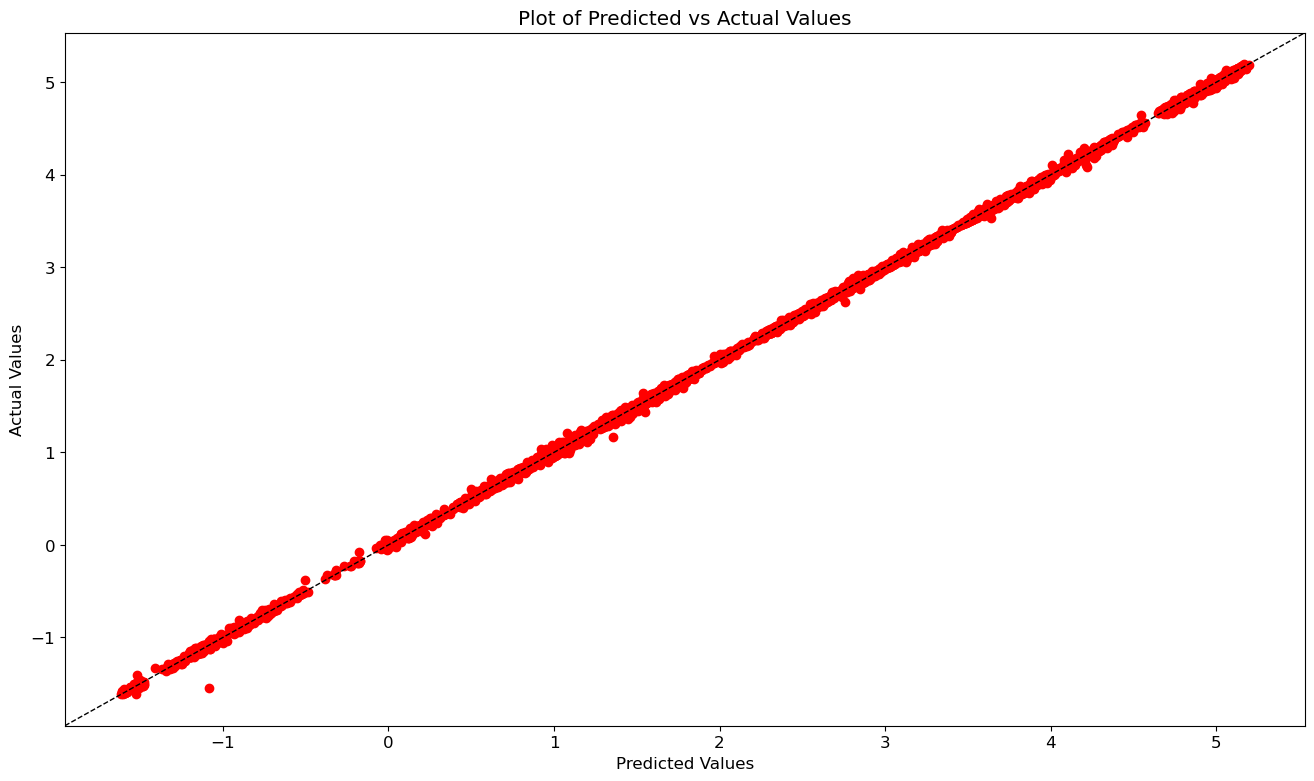

In [35]:
compare_actual_with_pred('AAPL')

0.27862745098039216

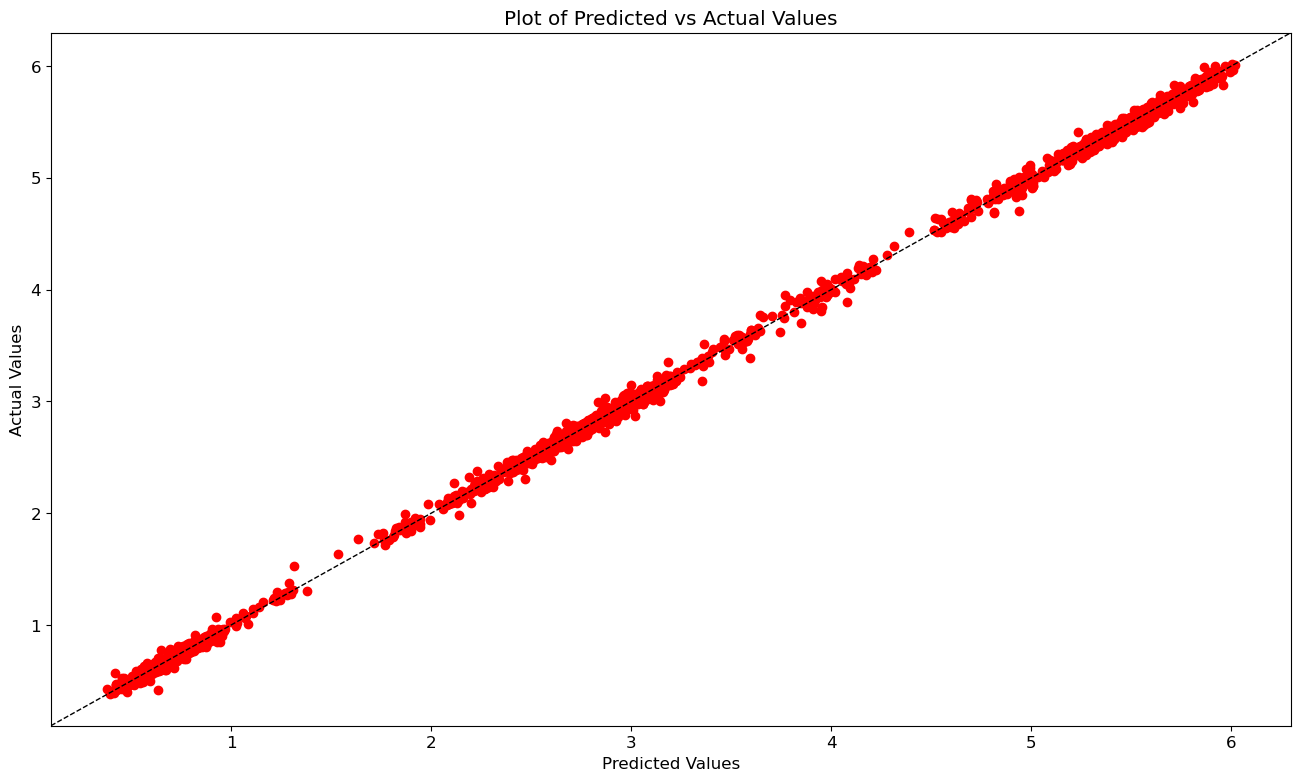

In [36]:
compare_actual_with_pred('TSLA')

0.4625490196078431

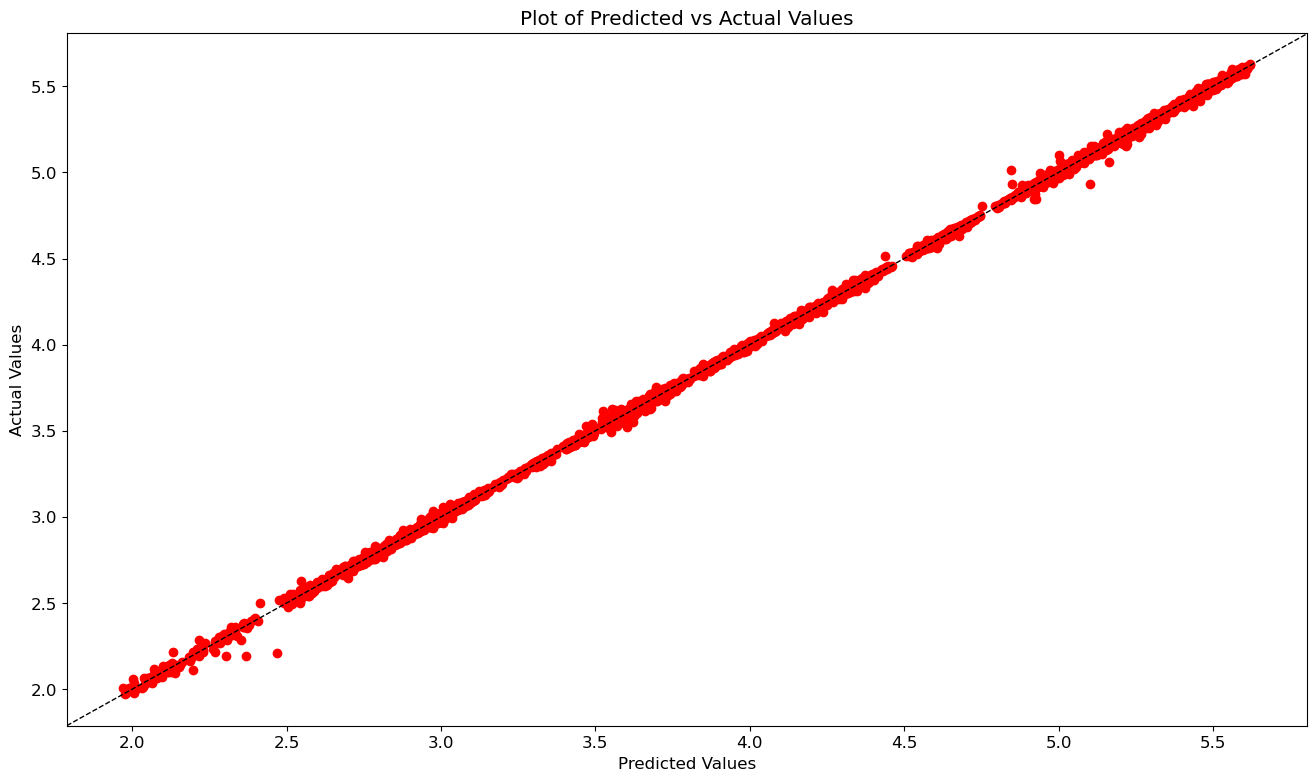

In [37]:
compare_actual_with_pred('MCD')